# Bayesian Logistic Regression using Hamiltonian Monte Carlo (A.K.A. Hybrid Monte Carlo)

This notebook aims to demonstrate on training a Bayesian logistic regression model. The example problem used in the notebook is a binary classification problem. We use Edward (https://github.com/blei-lab/edward) as a Python library to develop the model, since it bases on Tensorflow (https://www.tensorflow.org/) and supports running code on GPU. In particular, the notebook performs the following.

- Create a sample binary-classification dataset that is imbalanced (ratio = 1:9)
- Split the dataset into training and testset (20% test set)
- Define the model using edward. 
    - We assume Gaussian priors for all parameters for simplificity
    - For Bayesian inference, we use Empirical distribution for estimation
- 

In [ ]:
#!/usr/bin/env python
"""Bayesian logistic regression using Hamiltonian Monte Carlo.
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import pandas as pd
import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import tensorflow as tf
%matplotlib inline  
from edward.models import Bernoulli, Normal, Empirical

Define default GPU device

In [ ]:
DEFAULT_GPU_DEVICE = "/gpu:0"

In [35]:
num_features = 60  # number of features

from sklearn.datasets import make_classification
X_gen, Y_gen = make_classification(n_samples=10000, n_features=D,
                                    n_informative=10, n_redundant=50,
                                    random_state=42, weights={0:1.8, 1:1})

Look at the distribution of artificially created dataset

In [36]:
np.bincount(Y_gen)

array([8980, 1020])

Convert data to using float representation (required by current version of edward)

In [37]:
X_data = pd.DataFrame(X_gen.astype('float32'))
Y_data = pd.DataFrame(Y_gen.astype('float32'))

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.20,
                                                    random_state=42)

In [39]:
type(X_train)

pandas.core.frame.DataFrame

In [40]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

N = X_train.shape[0]
N

(8000, 60)
(8000, 1)
(2000, 60)
(2000, 1)


8000

# Model definition 

Define logistic regression function 

In [45]:
def logits_func(X, w, b):
  h = ed.dot(X, w) + b
  return tf.reshape(h, [-1])

Bayesian Logistic Regression Model

In [46]:

X = tf.placeholder(tf.float32, [N, D])
w = Normal(loc=tf.zeros(D, dtype=tf.float32),  scale=3.0 * tf.ones(D, dtype=tf.float32))
b = Normal(loc=tf.zeros([], dtype=tf.float32), scale=3.0 * tf.ones([], dtype=tf.float32))
y = Bernoulli(logits=tf.reshape(logits_func(X, w, b), [N, 1]), dtype=tf.float32)

In [47]:
y.shape

TensorShape([Dimension(8000), Dimension(1)])

Inference definition

In [48]:
T = 5000  # number of samples to sample for the empirical distribution
qw = Empirical(params=tf.Variable(tf.random_normal([T, D], dtype=tf.float32)))
qb = Empirical(params=tf.Variable(tf.random_normal([T], dtype=tf.float32)))

Verify that the prior and posterior estimation are of the same shapes

In [49]:
print(w.shape)
print(qw.shape)

(60,)
(60,)


In [50]:
print(b.shape)
print(qb.shape)

()
()


Execute the inferences

In [51]:
hmc_inference = ed.HMC({w: qw, b: qb}, data={X: X_train.values, y: Y_train.values})
hmc_inference.initialize(n_print=10, step_size=0.0005)

In [52]:
tf.global_variables_initializer().run()

In [53]:
for t in range(hmc_inference.n_iter):
  info_dict = hmc_inference.update()
  hmc_inference.print_progress(info_dict)

5000/5000 [100%] ██████████████████████████████ Elapsed: 21s | Acceptance Rate: 1.000


In [54]:
Y_test.iloc[10, 0]

0.0

Evaluatation code for a single sample

In [60]:
def eval_at_sample(index):
    print(" Real value is %s" % Y_test.iloc[index, 0])
    # Build samples from inferred posterior.
    num_samples = 100
    probs = tf.concat([tf.sigmoid(logits_func(X_test.iloc[index,:].values.reshape([1,D]), 
                                              qw.sample(),
                                              qb.sample()
                                             ))
                      for _ in range(num_samples)], axis=0)
    pd.DataFrame(probs.eval()).plot(kind="density")

# How does the predicted distribution of probability look like for class = 0?

 Real value is 0.0


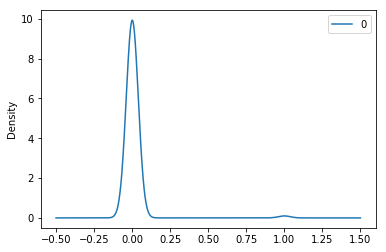

In [61]:
eval_at_sample(0)

 Real value is 0.0


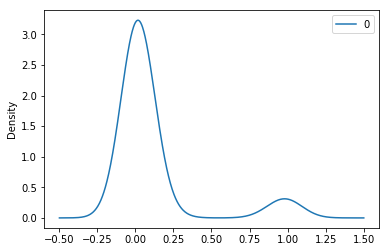

In [62]:
eval_at_sample(2)

 Real value is 0.0


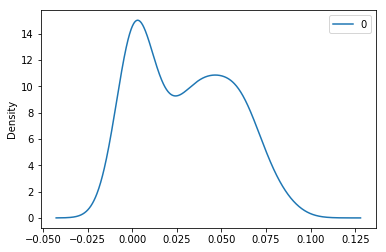

In [63]:
eval_at_sample(3)

 Real value is 0.0


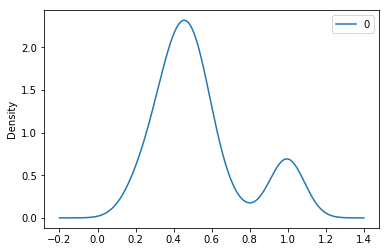

In [64]:
eval_at_sample(5)

 Real value is 0.0


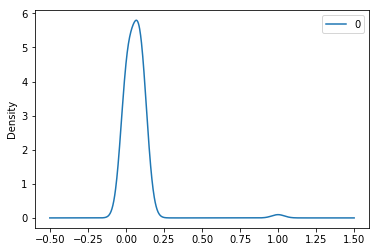

In [65]:
eval_at_sample(7)

 Real value is 0.0


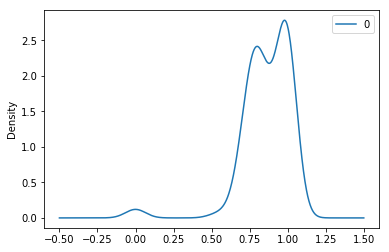

In [66]:
eval_at_sample(10)

* It looks quite promising

In [67]:
np.where(Y_test == 1)

(array([   9,   11,   23,   26,   29,   33,   46,   51,   62,   64,   72,
          83,   95,  104,  112,  113,  116,  122,  124,  128,  136,  138,
         144,  150,  159,  167,  170,  179,  190,  201,  205,  213,  221,
         224,  226,  236,  253,  261,  285,  295,  302,  315,  321,  326,
         337,  345,  346,  357,  358,  372,  385,  387,  392,  396,  418,
         422,  430,  448,  458,  481,  487,  499,  540,  549,  557,  560,
         575,  597,  602,  603,  604,  607,  635,  640,  656,  692,  700,
         716,  720,  738,  754,  781,  793,  797,  823,  830,  858,  862,
         864,  866,  887,  888,  890,  898,  900,  904,  914,  928,  935,
         946,  951,  952,  954,  967,  980,  987,  993,  994, 1021, 1027,
        1030, 1032, 1035, 1043, 1061, 1062, 1063, 1074, 1079, 1106, 1112,
        1113, 1116, 1139, 1140, 1142, 1151, 1156, 1166, 1171, 1177, 1187,
        1190, 1217, 1236, 1253, 1255, 1257, 1264, 1277, 1289, 1293, 1297,
        1299, 1303, 1305, 1313, 1317, 

# How does the predicted distribution of probability look like for class = 1?

 Real value is 1.0


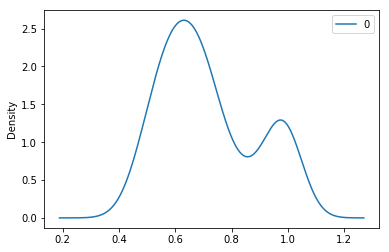

In [68]:
eval_at_sample(9)

 Real value is 1.0


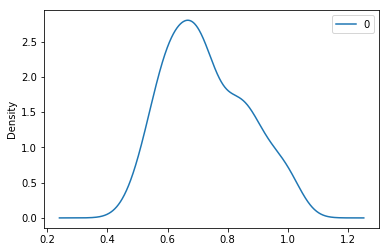

In [69]:
eval_at_sample(23)

 Real value is 1.0


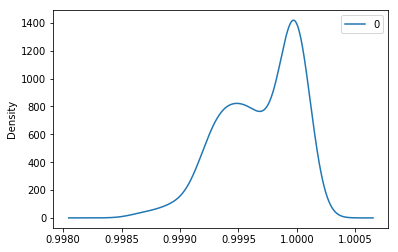

In [70]:
eval_at_sample(1995)

 Real value is 1.0


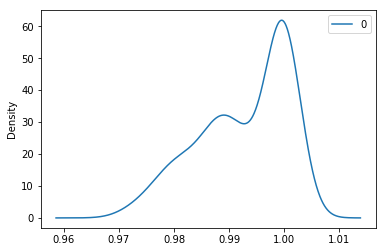

In [71]:
eval_at_sample(1623)

 Real value is 1.0


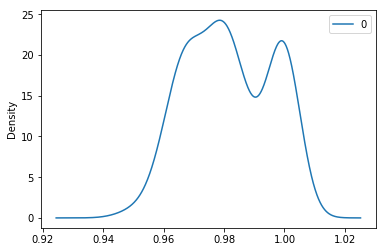

In [72]:
eval_at_sample(1632)

 Real value is 1.0


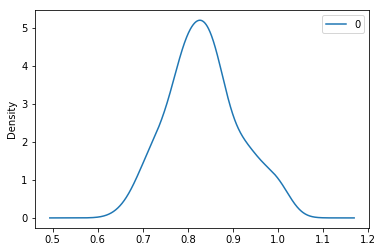

In [73]:
eval_at_sample(1804)

* It looks quite promising

# Evaluation experiments

We adopt minibatch prediction here to speed up the computation

In [74]:
from sklearn import metrics

In [75]:
batch_size = 5

In [76]:
selected_percentile = 30
selected_threshold  =  0.8

In [77]:
def probs_tensor_at_sample(X_row):
    num_predict_samples = 100
    return tf.concat([
        tf.sigmoid(logits_func(X_row, qw.sample(), qb.sample())) 
        for _ in range(num_predict_samples)], axis=0)

In [78]:
def probs_tensor_batch(X_rows_pl):
    return tf.stack([
                      probs_tensor_at_sample(
                          tf.reshape(X_rows_pl[i,:], [1, num_features]))
                      for i in range(X_rows_pl.shape[0])])

In [79]:
with tf.device(DEFAULT_GPU_DEVICE):
    X_rows_pl = tf.placeholder(tf.float32, [batch_size, num_features])
    tf_graph = probs_tensor_batch(X_rows_pl)

In [80]:
def prediction_decision_function(probs_output, Y_at_sample):
    print(" Real Y = %.2f : 25th = %.2f, 50th = %.2f, 75th = %.2f, 90th = %.2f" %
           ( Y_at_sample,
             np.percentile(probs_output, 25),
             np.percentile(probs_output, 50),
             np.percentile(probs_output, 75),
             np.percentile(probs_output, 90),
           )
         )    
    selected_percentile = 30
    selected_threshold  =  0.8
    if np.percentile(probs_output, selected_percentile) >= selected_threshold:
        return 1.0
    else:
        return 0.0
    

In [81]:
def eval_predict_at_batch(batch_offset, X, Y):
    X_rows =  X.iloc[batch_offset:(batch_offset + batch_size), :].values
    Y_rows =  Y.iloc[batch_offset:(batch_offset + batch_size)].values
    probs_batch_out = tf_graph.eval(feed_dict={X_rows_pl: X_rows})
    predict_batch_output = []
    predict_batch_percentiles = []
    for i in range(probs_batch_out.shape[0]):
        predict_batch_percentiles += [np.percentile(probs_batch_out[i], selected_percentile)]        
        predict_batch_output += [prediction_decision_function(
                                probs_batch_out[i], Y_rows[i])]
    return predict_batch_output, predict_batch_percentiles

In [82]:
def get_classification_results_text(Y_actual, Y_prediction):
    string_output = ""
    string_output += "accuracy = %.2f, precision = %.2f, recall = %.2f, F1-score = %.2f \n" % (
            metrics.accuracy_score(Y_actual, Y_prediction),
            metrics.precision_score(Y_actual, Y_prediction),
            metrics.recall_score(Y_actual, Y_prediction),
            metrics.f1_score(Y_actual, Y_prediction)
        )
    
    string_output += (" ---------- Confusion Matrix ------------\n")
    string_output += str(metrics.confusion_matrix(Y_actual, Y_prediction)) + "\n"
    string_output += (" ----------------------------------------\n")
    return string_output

In [83]:
def eval_classification_on_indexes(input_indexes, X, Y):
    num_batches  = len(input_indexes) // batch_size
    indexes      = input_indexes[:(num_batches * batch_size)]
    X_on_indexes = X.loc[indexes, :]
    Y_on_indexes = Y.loc[indexes]
    Y_predictions = []
    selected_percentiles = []
    
    for batch_index in range(num_batches):
        batch_offset = batch_index * batch_size
        print(" Processing at batch index %s at offset %s" % (batch_index, batch_offset))
        batch_predictions, batch_percentiles = eval_predict_at_batch(batch_offset, X_on_indexes, Y_on_indexes)
        Y_predictions += batch_predictions
        selected_percentiles += batch_percentiles
        
        
    return get_classification_results_text(Y_on_indexes, Y_predictions), selected_percentiles

In [84]:
def eval_classification_on_main(num_eval_samples, X, Y, Y_values_in=[0.0, 1.0]):    
    selected_indexes = Y[Y.apply(lambda x: x[0] in Y_values_in, axis=1)].sample(num_eval_samples).index
    result_text, selected_percentiles = eval_classification_on_indexes(selected_indexes, 
                                           X, 
                                           Y)
    print(" -------- Classification Summary -------------")
    print(result_text)
    print(" -------- Percentiles Summary -------------")
    print(pd.DataFrame(selected_percentiles).describe())

    

In [85]:
def eval_classification_on_indexes_test(num_eval_samples, Y_values_in=[0.0, 1.0]):
    eval_classification_on_main(num_eval_samples, X_test,  Y_test,  Y_values_in)

def eval_classification_on_indexes_train(num_eval_samples, Y_values_in=[0.0, 1.0]):
    eval_classification_on_main(num_eval_samples, X_train, Y_train, Y_values_in)



In [86]:
eval_classification_on_indexes_train(100)

 Processing at batch index 0 at offset 0
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.14, 50th = 0.27, 75th = 0.38, 90th = 0.47
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.02, 50th = 0.03, 75th = 0.04, 90th = 0.06
 Real Y = 0.00 : 25th = 0.13, 50th = 0.55, 75th = 0.64, 90th = 0.73
 Processing at batch index 1 at offset 5
 Real Y = 0.00 : 25th = 0.00, 50th = 0.01, 75th = 0.01, 90th = 0.01
 Real Y = 0.00 : 25th = 0.15, 50th = 0.22, 75th = 0.28, 90th = 0.33
 Real Y = 1.00 : 25th = 0.00, 50th = 0.38, 75th = 0.57, 90th = 0.65
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Processing at batch index 2 at offset 10
 Real Y = 0.00 : 25th = 0.00, 50th = 0.01, 75th = 0.01, 90th = 0.01
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.01, 75th = 0.01, 90th

In [87]:
eval_classification_on_indexes_test(100)

 Processing at batch index 0 at offset 0
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.01
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.01, 75th = 0.01, 90th = 0.02
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.02, 75th = 0.03, 90th = 0.04
 Processing at batch index 1 at offset 5
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.01, 75th = 0.02, 90th = 0.02
 Real Y = 1.00 : 25th = 0.21, 50th = 0.68, 75th = 0.77, 90th = 0.83
 Real Y = 0.00 : 25th = 0.02, 50th = 0.03, 75th = 0.03, 90th = 0.04
 Real Y = 0.00 : 25th = 0.10, 50th = 0.42, 75th = 0.49, 90th = 0.55
 Processing at batch index 2 at offset 10
 Real Y = 0.00 : 25th = 0.48, 50th = 0.63, 75th = 1.00, 90th = 1.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.01
 Real Y = 0.00 : 25th = 0.14, 50th = 0.20, 75th = 0.54, 90th

In [89]:
eval_classification_on_indexes_train(500)

 Processing at batch index 0 at offset 0
 Real Y = 1.00 : 25th = 1.00, 50th = 1.00, 75th = 1.00, 90th = 1.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.02, 75th = 0.04, 90th = 0.05
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.01, 90th = 0.01
 Real Y = 0.00 : 25th = 0.00, 50th = 0.02, 75th = 0.02, 90th = 0.03
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Processing at batch index 1 at offset 5
 Real Y = 0.00 : 25th = 0.00, 50th = 0.01, 75th = 0.01, 90th = 0.01
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.01
 Real Y = 0.00 : 25th = 0.00, 50th = 0.01, 75th = 0.02, 90th = 0.02
 Real Y = 0.00 : 25th = 0.00, 50th = 0.01, 75th = 0.02, 90th = 0.03
 Real Y = 1.00 : 25th = 0.88, 50th = 0.92, 75th = 1.00, 90th = 1.00
 Processing at batch index 2 at offset 10
 Real Y = 0.00 : 25th = 0.01, 50th = 0.05, 75th = 0.08, 90th = 0.12
 Real Y = 0.00 : 25th = 0.13, 50th = 0.31, 75th = 0.41, 90th = 0.44
 Real Y = 0.00 : 25th = 0.00, 50th = 0.01, 75th = 0.01, 90th

 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 1.00 : 25th = 0.03, 50th = 0.05, 75th = 0.08, 90th = 0.91
 Real Y = 0.00 : 25th = 0.00, 50th = 0.02, 75th = 0.03, 90th = 0.04
 Real Y = 0.00 : 25th = 0.00, 50th = 0.01, 75th = 0.01, 90th = 0.02
 Real Y = 0.00 : 25th = 0.01, 50th = 0.09, 75th = 0.14, 90th = 0.18
 Processing at batch index 24 at offset 120
 Real Y = 0.00 : 25th = 0.00, 50th = 0.01, 75th = 0.03, 90th = 0.04
 Real Y = 0.00 : 25th = 0.01, 50th = 0.11, 75th = 0.19, 90th = 0.25
 Real Y = 0.00 : 25th = 0.00, 50th = 0.01, 75th = 0.01, 90th = 0.01
 Real Y = 0.00 : 25th = 0.00, 50th = 0.01, 75th = 0.01, 90th = 0.02
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Processing at batch index 25 at offset 125
 Real Y = 0.00 : 25th = 0.01, 50th = 0.02, 75th = 0.03, 90th = 0.04
 Real Y = 1.00 : 25th = 0.67, 50th = 0.75, 75th = 0.92, 90th = 1.00
 Real Y = 0.00 : 25th = 0.01, 50th = 0.05, 75th = 0.06, 90th = 0.08
 Real Y = 0.00 : 25th = 0.03

 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.15, 50th = 0.21, 75th = 0.26, 90th = 0.34
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.17, 50th = 0.22, 75th = 0.30, 90th = 0.56
 Processing at batch index 47 at offset 235
 Real Y = 0.00 : 25th = 0.00, 50th = 0.01, 75th = 0.01, 90th = 0.01
 Real Y = 0.00 : 25th = 0.04, 50th = 0.15, 75th = 0.21, 90th = 0.35
 Real Y = 0.00 : 25th = 0.91, 50th = 0.95, 75th = 1.00, 90th = 1.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.01, 75th = 0.02, 90th = 0.02
 Processing at batch index 48 at offset 240
 Real Y = 1.00 : 25th = 0.54, 50th = 0.94, 75th = 0.96, 90th = 0.97
 Real Y = 0.00 : 25th = 0.38, 50th = 0.47, 75th = 0.53, 90th = 0.64
 Real Y = 0.00 : 25th = 0.02, 50th = 0.04, 75th = 0.05, 90th = 0.06
 Real Y = 0.00 : 25th = 0.00

 Real Y = 1.00 : 25th = 0.90, 50th = 0.93, 75th = 0.95, 90th = 0.96
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.01, 50th = 0.02, 75th = 0.03, 90th = 0.06
 Real Y = 0.00 : 25th = 0.81, 50th = 0.86, 75th = 0.89, 90th = 0.94
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Processing at batch index 70 at offset 350
 Real Y = 0.00 : 25th = 0.17, 50th = 0.24, 75th = 0.29, 90th = 0.37
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 1.00 : 25th = 0.97, 50th = 0.98, 75th = 0.99, 90th = 0.99
 Real Y = 0.00 : 25th = 0.28, 50th = 0.37, 75th = 0.91, 90th = 1.00
 Real Y = 0.00 : 25th = 0.26, 50th = 0.32, 75th = 0.51, 90th = 0.99
 Processing at batch index 71 at offset 355
 Real Y = 0.00 : 25th = 0.00, 50th = 0.05, 75th = 0.08, 90th = 0.11
 Real Y = 0.00 : 25th = 0.16, 50th = 0.21, 75th = 0.77, 90th = 1.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 1.00 : 25th = 0.98

 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.01
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.01
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.01
 Processing at batch index 93 at offset 465
 Real Y = 0.00 : 25th = 0.00, 50th = 0.01, 75th = 0.01, 90th = 0.01
 Real Y = 0.00 : 25th = 0.07, 50th = 0.09, 75th = 0.11, 90th = 0.16
 Real Y = 0.00 : 25th = 0.02, 50th = 0.04, 75th = 0.07, 90th = 0.09
 Real Y = 0.00 : 25th = 0.00, 50th = 0.03, 75th = 0.04, 90th = 0.05
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Processing at batch index 94 at offset 470
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.02, 75th = 0.04, 90th = 0.07
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.00

In [88]:
eval_classification_on_indexes_test(500)

 Processing at batch index 0 at offset 0
 Real Y = 0.00 : 25th = 0.01, 50th = 0.02, 75th = 0.04, 90th = 0.08
 Real Y = 0.00 : 25th = 0.00, 50th = 0.07, 75th = 0.11, 90th = 1.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 1.00 : 25th = 0.92, 50th = 0.95, 75th = 1.00, 90th = 1.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.02, 75th = 0.03, 90th = 0.03
 Processing at batch index 1 at offset 5
 Real Y = 1.00 : 25th = 0.01, 50th = 0.01, 75th = 0.02, 90th = 0.12
 Real Y = 0.00 : 25th = 0.00, 50th = 0.01, 75th = 0.01, 90th = 0.01
 Real Y = 0.00 : 25th = 0.02, 50th = 0.03, 75th = 0.04, 90th = 0.05
 Real Y = 0.00 : 25th = 0.10, 50th = 0.17, 75th = 0.24, 90th = 0.28
 Real Y = 0.00 : 25th = 0.38, 50th = 0.47, 75th = 0.76, 90th = 0.96
 Processing at batch index 2 at offset 10
 Real Y = 0.00 : 25th = 0.00, 50th = 0.05, 75th = 0.09, 90th = 0.12
 Real Y = 0.00 : 25th = 0.62, 50th = 0.68, 75th = 0.74, 90th = 0.81
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th

 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.01, 50th = 0.01, 75th = 0.02, 90th = 0.05
 Real Y = 0.00 : 25th = 0.01, 50th = 0.01, 75th = 0.02, 90th = 0.03
 Real Y = 0.00 : 25th = 0.03, 50th = 0.06, 75th = 0.09, 90th = 0.27
 Real Y = 0.00 : 25th = 0.80, 50th = 0.86, 75th = 0.91, 90th = 0.97
 Processing at batch index 25 at offset 125
 Real Y = 0.00 : 25th = 0.31, 50th = 0.38, 75th = 0.48, 90th = 0.93
 Real Y = 0.00 : 25th = 0.00, 50th = 0.01, 75th = 0.02, 90th = 0.03
 Real Y = 1.00 : 25th = 0.07, 50th = 0.36, 75th = 0.54, 90th = 0.61
 Real Y = 0.00 : 25th = 0.00, 50th = 0.02, 75th = 0.03, 90th = 1.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.05, 75th = 0.11, 90th = 0.15
 Processing at batch index 26 at offset 130
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.01, 90th = 0.01
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.00

 Real Y = 0.00 : 25th = 0.00, 50th = 0.01, 75th = 0.01, 90th = 0.03
 Real Y = 1.00 : 25th = 0.94, 50th = 0.95, 75th = 0.97, 90th = 0.99
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 1.00 : 25th = 0.02, 50th = 0.94, 75th = 0.97, 90th = 0.98
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Processing at batch index 47 at offset 235
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.02, 50th = 0.09, 75th = 0.14, 90th = 0.18
 Real Y = 0.00 : 25th = 0.00, 50th = 0.01, 75th = 0.01, 90th = 0.02
 Real Y = 0.00 : 25th = 0.01, 50th = 0.01, 75th = 0.01, 90th = 0.02
 Real Y = 0.00 : 25th = 0.00, 50th = 0.02, 75th = 0.03, 90th = 0.05
 Processing at batch index 48 at offset 240
 Real Y = 0.00 : 25th = 0.00, 50th = 0.04, 75th = 0.08, 90th = 0.12
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 1.00 : 25th = 0.97, 50th = 0.98, 75th = 1.00, 90th = 1.00
 Real Y = 1.00 : 25th = 0.96

 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.01, 90th = 0.01
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.01
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.01, 75th = 0.01, 90th = 0.01
 Real Y = 0.00 : 25th = 0.00, 50th = 0.01, 75th = 0.01, 90th = 0.01
 Processing at batch index 69 at offset 345
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.02, 75th = 0.02, 90th = 0.03
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.02, 75th = 0.03, 90th = 0.04
 Processing at batch index 70 at offset 350
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.01, 75th = 0.02, 90th = 0.03
 Real Y = 0.00 : 25th = 0.02, 50th = 0.11, 75th = 0.15, 90th = 1.00
 Real Y = 0.00 : 25th = 0.00

 Real Y = 0.00 : 25th = 0.01, 50th = 0.02, 75th = 0.03, 90th = 0.04
 Real Y = 0.00 : 25th = 0.00, 50th = 0.01, 75th = 0.01, 90th = 0.02
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.02, 75th = 0.04, 90th = 0.05
 Processing at batch index 92 at offset 460
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.05, 50th = 0.08, 75th = 0.10, 90th = 0.13
 Real Y = 0.00 : 25th = 0.00, 50th = 0.01, 75th = 0.03, 90th = 0.04
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Processing at batch index 93 at offset 465
 Real Y = 0.00 : 25th = 0.47, 50th = 0.58, 75th = 1.00, 90th = 1.00
 Real Y = 0.00 : 25th = 0.02, 50th = 0.12, 75th = 0.19, 90th = 0.24
 Real Y = 0.00 : 25th = 0.01, 50th = 0.04, 75th = 0.07, 90th = 0.14
 Real Y = 0.00 : 25th = 0.01

In [90]:
eval_classification_on_indexes_test(2000)

 Processing at batch index 0 at offset 0
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.01, 50th = 0.02, 75th = 0.03, 90th = 0.03
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.01
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.03, 75th = 0.04, 90th = 0.06
 Processing at batch index 1 at offset 5
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 1.00 : 25th = 0.99, 50th = 0.99, 75th = 1.00, 90th = 1.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.01
 Processing at batch index 2 at offset 10
 Real Y = 0.00 : 25th = 0.14, 50th = 0.18, 75th = 0.25, 90th = 0.77
 Real Y = 0.00 : 25th = 0.19, 50th = 0.25, 75th = 0.90, 90th = 1.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th

 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.01, 90th = 0.01
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Processing at batch index 24 at offset 120
 Real Y = 0.00 : 25th = 0.03, 50th = 0.09, 75th = 0.14, 90th = 0.20
 Real Y = 0.00 : 25th = 0.00, 50th = 0.04, 75th = 0.08, 90th = 0.11
 Real Y = 0.00 : 25th = 0.00, 50th = 0.01, 75th = 0.01, 90th = 0.03
 Real Y = 0.00 : 25th = 0.00, 50th = 0.02, 75th = 0.03, 90th = 0.05
 Real Y = 0.00 : 25th = 0.00, 50th = 0.01, 75th = 0.04, 90th = 0.05
 Processing at batch index 25 at offset 125
 Real Y = 0.00 : 25th = 0.14, 50th = 0.19, 75th = 0.23, 90th = 0.28
 Real Y = 1.00 : 25th = 0.99, 50th = 0.99, 75th = 1.00, 90th = 1.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.01
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.01
 Real Y = 0.00 : 25th = 0.00, 50th = 0.02, 75th = 0.03, 90th = 0.04
 Processing at batch index 26 at offset 130
 Real Y = 1.00 : 25th = 0.99, 50th = 0.99, 75th = 1.

 Real Y = 0.00 : 25th = 0.00, 50th = 0.01, 75th = 0.02, 90th = 0.03
 Real Y = 1.00 : 25th = 0.96, 50th = 0.98, 75th = 0.98, 90th = 0.99
 Real Y = 1.00 : 25th = 0.88, 50th = 0.90, 75th = 0.93, 90th = 0.98
 Real Y = 0.00 : 25th = 0.02, 50th = 0.08, 75th = 0.11, 90th = 0.13
 Real Y = 1.00 : 25th = 0.44, 50th = 0.56, 75th = 0.99, 90th = 1.00
 Processing at batch index 47 at offset 235
 Real Y = 0.00 : 25th = 0.02, 50th = 0.12, 75th = 0.20, 90th = 0.30
 Real Y = 1.00 : 25th = 0.98, 50th = 0.99, 75th = 0.99, 90th = 1.00
 Real Y = 0.00 : 25th = 0.22, 50th = 0.27, 75th = 0.41, 90th = 0.74
 Real Y = 1.00 : 25th = 0.12, 50th = 0.17, 75th = 0.29, 90th = 0.96
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.01
 Processing at batch index 48 at offset 240
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.02, 75th = 0.03, 90th = 0.04
 Real Y = 0.00 : 25th = 0.63, 50th = 0.71, 75th = 0.80, 90th = 0.87
 Real Y = 0.00 : 25th = 0.00

 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.07, 75th = 0.09, 90th = 0.11
 Real Y = 0.00 : 25th = 0.02, 50th = 0.03, 75th = 0.03, 90th = 0.04
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Processing at batch index 71 at offset 355
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 1.00 : 25th = 0.14, 50th = 0.60, 75th = 0.68, 90th = 0.72
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.01, 75th = 0.01, 90th = 0.87
 Processing at batch index 72 at offset 360
 Real Y = 0.00 : 25th = 0.00, 50th = 0.01, 75th = 0.01, 90th = 0.01
 Real Y = 1.00 : 25th = 0.98, 50th = 0.99, 75th = 1.00, 90th = 1.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.01, 75th = 0.02, 90th = 0.83
 Real Y = 0.00 : 25th = 0.00

 Real Y = 0.00 : 25th = 0.02, 50th = 0.07, 75th = 0.09, 90th = 0.11
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.01, 90th = 0.01
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Processing at batch index 94 at offset 470
 Real Y = 0.00 : 25th = 0.00, 50th = 0.01, 75th = 0.02, 90th = 0.03
 Real Y = 0.00 : 25th = 0.02, 50th = 0.02, 75th = 0.05, 90th = 1.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.21, 50th = 0.33, 75th = 0.40, 90th = 0.47
 Processing at batch index 95 at offset 475
 Real Y = 0.00 : 25th = 0.00, 50th = 0.05, 75th = 0.08, 90th = 0.10
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.01, 75th = 0.02, 90th = 0.02
 Real Y = 0.00 : 25th = 0.00

 Real Y = 0.00 : 25th = 0.28, 50th = 0.37, 75th = 0.84, 90th = 0.99
 Real Y = 0.00 : 25th = 0.00, 50th = 0.01, 75th = 0.02, 90th = 0.02
 Real Y = 0.00 : 25th = 0.00, 50th = 0.01, 75th = 0.01, 90th = 0.01
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 1.00 : 25th = 1.00, 50th = 1.00, 75th = 1.00, 90th = 1.00
 Processing at batch index 117 at offset 585
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.01, 90th = 0.02
 Real Y = 0.00 : 25th = 0.00, 50th = 0.01, 75th = 0.01, 90th = 0.01
 Real Y = 0.00 : 25th = 0.00, 50th = 0.01, 75th = 0.02, 90th = 0.02
 Real Y = 0.00 : 25th = 0.26, 50th = 0.33, 75th = 0.41, 90th = 0.46
 Processing at batch index 118 at offset 590
 Real Y = 0.00 : 25th = 0.00, 50th = 0.02, 75th = 0.02, 90th = 0.03
 Real Y = 0.00 : 25th = 0.01, 50th = 0.05, 75th = 0.08, 90th = 0.10
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.

 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.01
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.01
 Real Y = 0.00 : 25th = 0.01, 50th = 0.04, 75th = 0.06, 90th = 0.09
 Real Y = 1.00 : 25th = 0.15, 50th = 0.60, 75th = 0.68, 90th = 0.74
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Processing at batch index 140 at offset 700
 Real Y = 0.00 : 25th = 0.00, 50th = 0.01, 75th = 0.02, 90th = 0.03
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.80, 50th = 0.84, 75th = 0.90, 90th = 1.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.34, 50th = 0.43, 75th = 0.53, 90th = 0.68
 Processing at batch index 141 at offset 705
 Real Y = 0.00 : 25th = 0.02, 50th = 0.04, 75th = 0.06, 90th = 0.08
 Real Y = 0.00 : 25th = 0.45, 50th = 0.52, 75th = 0.67, 90th = 0.85
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.01, 90th = 0.01
 Real Y = 0.00 : 25th = 0.

 Real Y = 0.00 : 25th = 0.00, 50th = 0.01, 75th = 0.03, 90th = 0.04
 Real Y = 1.00 : 25th = 0.08, 50th = 0.78, 75th = 0.89, 90th = 0.93
 Real Y = 0.00 : 25th = 0.51, 50th = 0.58, 75th = 0.67, 90th = 0.86
 Real Y = 0.00 : 25th = 0.01, 50th = 0.04, 75th = 0.06, 90th = 0.08
 Real Y = 1.00 : 25th = 0.96, 50th = 0.98, 75th = 1.00, 90th = 1.00
 Processing at batch index 162 at offset 810
 Real Y = 0.00 : 25th = 0.14, 50th = 0.19, 75th = 0.74, 90th = 1.00
 Real Y = 1.00 : 25th = 0.74, 50th = 0.94, 75th = 0.96, 90th = 0.97
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.01, 90th = 0.01
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.02, 50th = 0.07, 75th = 0.09, 90th = 0.11
 Processing at batch index 163 at offset 815
 Real Y = 0.00 : 25th = 0.01, 50th = 0.01, 75th = 0.02, 90th = 0.03
 Real Y = 0.00 : 25th = 0.76, 50th = 0.82, 75th = 0.86, 90th = 0.93
 Real Y = 0.00 : 25th = 0.22, 50th = 0.26, 75th = 0.32, 90th = 0.36
 Real Y = 0.00 : 25th = 0.

 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.01
 Real Y = 0.00 : 25th = 0.00, 50th = 0.01, 75th = 0.01, 90th = 0.02
 Real Y = 1.00 : 25th = 0.02, 50th = 0.07, 75th = 0.13, 90th = 0.23
 Processing at batch index 186 at offset 930
 Real Y = 0.00 : 25th = 0.62, 50th = 0.68, 75th = 0.80, 90th = 1.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.02, 75th = 0.02, 90th = 0.03
 Real Y = 0.00 : 25th = 0.00, 50th = 0.03, 75th = 0.04, 90th = 0.05
 Real Y = 0.00 : 25th = 0.01, 50th = 0.04, 75th = 0.06, 90th = 0.08
 Processing at batch index 187 at offset 935
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.01, 50th = 0.02, 75th = 0.04, 90th = 0.19
 Real Y = 1.00 : 25th = 0.72, 50th = 0.82, 75th = 0.88, 90th = 0.92
 Real Y = 0.00 : 25th = 0.

 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.01, 90th = 0.01
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.02, 90th = 0.03
 Real Y = 0.00 : 25th = 0.00, 50th = 0.01, 75th = 0.03, 90th = 0.03
 Real Y = 0.00 : 25th = 0.11, 50th = 0.18, 75th = 0.23, 90th = 0.27
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Processing at batch index 209 at offset 1045
 Real Y = 0.00 : 25th = 0.35, 50th = 0.44, 75th = 0.53, 90th = 0.59
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 1.00 : 25th = 0.61, 50th = 0.86, 75th = 1.00, 90th = 1.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Processing at batch index 210 at offset 1050
 Real Y = 0.00 : 25th = 0.00, 50th = 0.01, 75th = 0.02, 90th = 0.03
 Real Y = 0.00 : 25th = 0.67, 50th = 0.78, 75th = 1.00, 90th = 1.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.01
 Real Y = 0.00 : 25th = 

 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.01, 75th = 0.02, 90th = 0.03
 Processing at batch index 231 at offset 1155
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.02
 Real Y = 1.00 : 25th = 0.93, 50th = 0.95, 75th = 1.00, 90th = 1.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.01, 75th = 0.01, 90th = 0.01
 Real Y = 1.00 : 25th = 0.98, 50th = 0.99, 75th = 1.00, 90th = 1.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.02, 75th = 0.03, 90th = 0.04
 Processing at batch index 232 at offset 1160
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.01, 50th = 0.02, 75th = 0.03, 90th = 0.03
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 

 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.04, 75th = 0.06, 90th = 0.07
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.01, 90th = 0.02
 Real Y = 1.00 : 25th = 0.00, 50th = 0.01, 75th = 0.02, 90th = 0.03
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Processing at batch index 254 at offset 1270
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.01, 90th = 0.01
 Real Y = 1.00 : 25th = 1.00, 50th = 1.00, 75th = 1.00, 90th = 1.00
 Real Y = 0.00 : 25th = 0.07, 50th = 0.11, 75th = 0.16, 90th = 0.19
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.19
 Real Y = 1.00 : 25th = 0.98, 50th = 0.99, 75th = 1.00, 90th = 1.00
 Processing at batch index 255 at offset 1275
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.02, 50th = 0.02, 75th = 0.06, 90th = 0.56
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.01, 90th = 0.01
 Real Y = 0.00 : 25th = 

 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.01, 75th = 0.01, 90th = 0.01
 Real Y = 0.00 : 25th = 0.00, 50th = 0.01, 75th = 0.01, 90th = 0.02
 Real Y = 0.00 : 25th = 0.01, 50th = 0.04, 75th = 0.07, 90th = 0.09
 Processing at batch index 276 at offset 1380
 Real Y = 0.00 : 25th = 0.00, 50th = 0.01, 75th = 0.01, 90th = 0.01
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.05, 50th = 0.07, 75th = 0.09, 90th = 0.77
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.01, 75th = 0.02, 90th = 0.03
 Processing at batch index 277 at offset 1385
 Real Y = 0.00 : 25th = 0.00, 50th = 0.03, 75th = 0.05, 90th = 0.06
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.01, 90th = 0.01
 Real Y = 0.00 : 25th = 0.00, 50th = 0.02, 75th = 0.04, 90th = 0.05
 Real Y = 0.00 : 25th = 

 Real Y = 0.00 : 25th = 0.00, 50th = 0.01, 75th = 0.02, 90th = 0.02
 Real Y = 1.00 : 25th = 1.00, 50th = 1.00, 75th = 1.00, 90th = 1.00
 Real Y = 1.00 : 25th = 0.95, 50th = 0.97, 75th = 1.00, 90th = 1.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.66, 50th = 0.72, 75th = 0.86, 90th = 0.97
 Processing at batch index 299 at offset 1495
 Real Y = 0.00 : 25th = 0.00, 50th = 0.02, 75th = 0.03, 90th = 0.04
 Real Y = 1.00 : 25th = 0.69, 50th = 0.75, 75th = 0.84, 90th = 0.93
 Real Y = 0.00 : 25th = 0.01, 50th = 0.03, 75th = 0.04, 90th = 0.05
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.01, 90th = 0.01
 Processing at batch index 300 at offset 1500
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.01, 90th = 0.01
 Real Y = 0.00 : 25th = 0.00, 50th = 0.01, 75th = 0.02, 90th = 0.03
 Real Y = 0.00 : 25th = 0.10, 50th = 0.33, 75th = 0.40, 90th = 0.45
 Real Y = 0.00 : 25th = 

 Real Y = 0.00 : 25th = 0.48, 50th = 0.54, 75th = 0.59, 90th = 0.66
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 1.00 : 25th = 0.06, 50th = 0.10, 75th = 0.13, 90th = 0.17
 Real Y = 0.00 : 25th = 0.00, 50th = 0.01, 75th = 0.01, 90th = 0.02
 Processing at batch index 322 at offset 1610
 Real Y = 0.00 : 25th = 0.00, 50th = 0.01, 75th = 0.01, 90th = 0.01
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.20, 50th = 0.26, 75th = 0.39, 90th = 1.00
 Processing at batch index 323 at offset 1615
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.01, 90th = 0.01
 Real Y = 0.00 : 25th = 0.01, 50th = 0.06, 75th = 0.08, 90th = 0.09
 Real Y = 0.00 : 25th = 0.00, 50th = 0.01, 75th = 0.02, 90th = 0.02
 Real Y = 0.00 : 25th = 

 Real Y = 0.00 : 25th = 0.06, 50th = 0.10, 75th = 0.13, 90th = 0.15
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.11, 50th = 0.16, 75th = 0.37, 90th = 0.97
 Processing at batch index 343 at offset 1715
 Real Y = 0.00 : 25th = 0.00, 50th = 0.01, 75th = 0.02, 90th = 0.02
 Real Y = 0.00 : 25th = 0.60, 50th = 0.67, 75th = 1.00, 90th = 1.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.01, 75th = 0.02, 90th = 0.02
 Real Y = 0.00 : 25th = 0.00, 50th = 0.03, 75th = 0.04, 90th = 0.06
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Processing at batch index 344 at offset 1720
 Real Y = 0.00 : 25th = 0.01, 50th = 0.02, 75th = 0.04, 90th = 0.99
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.05, 75th = 0.07, 90th = 0.09
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.01
 Real Y = 0.00 : 25th = 0.06, 50th = 0.08, 75th = 0.10, 90th = 0.15
 Processing at batch ind

 Real Y = 0.00 : 25th = 0.00, 50th = 0.03, 75th = 0.04, 90th = 0.05
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.62, 50th = 0.70, 75th = 0.99, 90th = 1.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Processing at batch index 366 at offset 1830
 Real Y = 0.00 : 25th = 0.33, 50th = 0.38, 75th = 0.47, 90th = 0.80
 Real Y = 0.00 : 25th = 0.00, 50th = 0.01, 75th = 0.03, 90th = 0.03
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Processing at batch index 367 at offset 1835
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.01, 90th = 0.01
 Real Y = 1.00 : 25th = 0.99, 50th = 0.99, 75th = 1.00, 90th = 1.00
 Real Y = 0.00 : 25th = 0.06, 50th = 0.08, 75th = 0.24, 90th = 0.99
 Real Y = 0.00 : 25th = 

 Real Y = 0.00 : 25th = 0.11, 50th = 0.14, 75th = 0.34, 90th = 0.80
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.01
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.02, 50th = 0.06, 75th = 0.08, 90th = 0.09
 Processing at batch index 389 at offset 1945
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.01, 90th = 0.01
 Real Y = 0.00 : 25th = 0.00, 50th = 0.01, 75th = 0.02, 90th = 0.03
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.00, 50th = 0.01, 75th = 0.01, 90th = 0.01
 Processing at batch index 390 at offset 1950
 Real Y = 0.00 : 25th = 0.00, 50th = 0.00, 75th = 0.00, 90th = 0.00
 Real Y = 0.00 : 25th = 0.04, 50th = 0.06, 75th = 0.10, 90th = 0.59
 Real Y = 0.00 : 25th = 0.01, 50th = 0.04, 75th = 0.06, 90th = 0.07
 Real Y = 0.00 : 25th = 0.00, 50th = 0.03, 75th = 0.04, 90th = 0.06
 Real Y = 0.00 : 25th = 